## Goal:

Show:
- Narrow thing: How to make infections, ratio, and deaths predictions on Metaculus more consistent with each other
- Broad thing: Workflow that connects judgmental and model-based forecasting

## Setup:

In [0]:
import ergo
import seaborn
import numpy as np

In [0]:
metaculus = ergo.Metaculus(username="", password="")

## Look at questions
* https://www.metaculus.com/questions/3529/how-many-infections-of-covid-19-will-be-estimated-to-have-occurred-before-2021-50k-1b-range/
* https://www.metaculus.com/questions/3530/how-many-people-will-die-as-a-result-of-the-2019-novel-coronavirus-covid-19-before-2021/
* https://www.metaculus.com/questions/3755/what-will-be-the-ratio-of-fatalities-to-total-estimated-infections-for-covid-19-by-the-end-of-2020/



Retrieve the questions we want to model, using IDs from URLs:

In [3]:
q_infections = metaculus.get_question(3529, name="infections")
q_deaths = metaculus.get_question(3530, name="deaths")
q_ratio = metaculus.get_question(3755, name="ratio")

questions = [q_infections, q_deaths, q_ratio]

ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3529,infections,How many infections of COVID-19 will be estima...,2021-01-01 00:00:00+00:00
1,3530,deaths,How many people will die as a result of the 20...,2021-01-01 00:00:00+00:00
2,3755,ratio,What will be the ratio of fatalities to total ...,2021-01-01 05:00:00+00:00


[array([ 6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.]), <a list of 11 Text major ticklabel objects>]


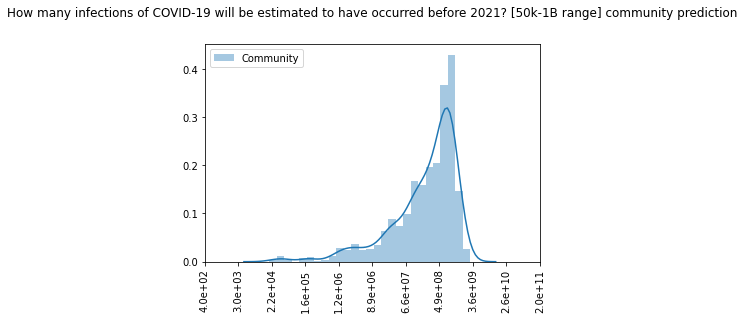

In [4]:
import matplotlib.pyplot as pyplot
import math

self = q_infections

pyplot.title(f"{self} community prediction", y=1.1)

community_samples = np.log([self.sample_community() for _ in range(0, 1000)])


ax = seaborn.distplot(
    community_samples, label="Community")

print([log_tick for log_tick in pyplot.xticks()])

pyplot.xticks(pyplot.xticks()[0], [f"{math.exp(log_tick):.1e}" for log_tick in pyplot.xticks()[0]], rotation="vertical")

pyplot.legend()

Let's see the current community estimate for each question:

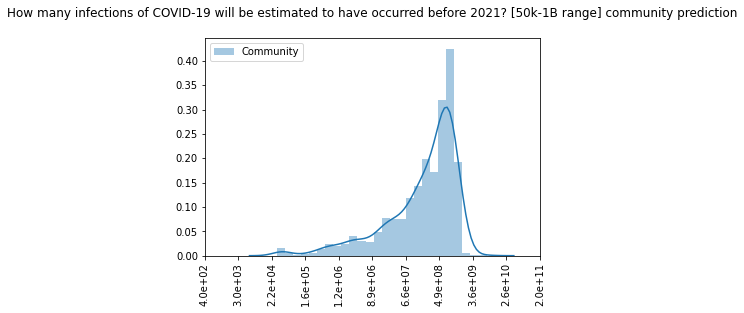

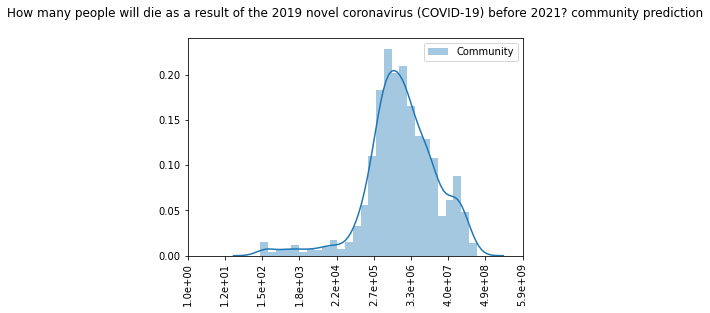

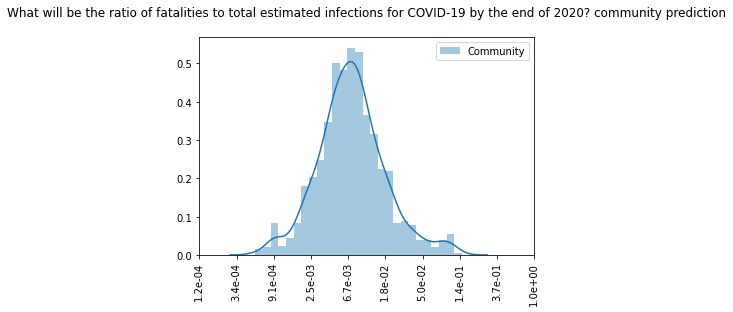

[None, None, None]

In [5]:
[question.show_community_prediction() for question in questions]

## Build a model that relates the questions

In [27]:
def deaths_from_infections():
  infections = q_infections.sample_community()
  ratio = q_ratio.sample_community()
  deaths_from_q = q_deaths.sample_community()
  deaths = infections * ratio
  ergo.tag(deaths, "model_deaths")
  return deaths

samples = ergo.run(deaths_from_infections, num_samples=5000)

100%|██████████| 5000/5000 [00:07<00:00, 710.00it/s]


In [28]:
samples.describe()

,infections,ratio,deaths,model_deaths
count,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03
mean,5.104415e+08,0.011507,1.219429e+07,5.764553e+06
std,4.799999e+08,0.015366,3.053101e+07,1.166724e+07
min,2.401179e+04,0.000603,6.897430e+01,4.122041e+01
25%,8.103894e+07,0.004139,4.732027e+05,4.921721e+05
50%,3.921344e+08,0.007173,1.635896e+06,2.336355e+06
75%,8.386156e+08,0.012432,6.878973e+06,6.455489e+06
max,3.630175e+09,0.185211,4.841243e+08,2.355250e+08


### Combine our model with the community prediction

100%|██████████| 5000/5000 [00:13<00:00, 376.78it/s]


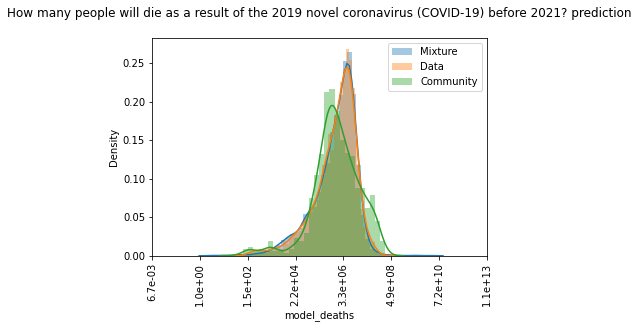

In [29]:
q_deaths.show_submission(samples["model_deaths"], show_community=True)

Mostly defer to community's estimates of death directly, but to the
extent that it's inconsistent with what community estimates for ratio
and infections imply, we want to update in that direction. so
mix our model estimate with community prediction for deaths:

In [31]:
def deaths_adjusted():
  if ergo.flip(.66):
    deaths = q_deaths.sample_community()
  else:
    deaths = deaths_from_infections()
  # print(deaths)
  ergo.tag(deaths, "deaths_adjusted")

samples = ergo.run(deaths_adjusted, num_samples=5000)

adjusted_samples = samples["deaths_adjusted"]

100%|██████████| 5000/5000 [00:05<00:00, 992.83it/s] 


100%|██████████| 5000/5000 [00:12<00:00, 396.43it/s]


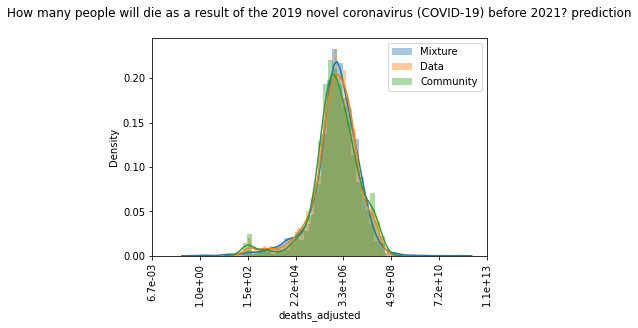

In [32]:
q_deaths.show_submission(adjusted_samples, show_community=True)

Submit new distribution on deaths to Metaculus

In [11]:
q_deaths.submit_from_samples(adjusted_samples)

100%|██████████| 5000/5000 [00:14<00:00, 353.32it/s]


<Response [202]>

**Exercise:** Apply the same idea to estimating infections from deaths